It is Oct 13, 2016. NASA’s radars discovered a small, 3 meter iron base meteorite, that just entered the Earth’s atmosphere. A small meteorite will not create a big devastation but still dangerous for the citizens. Local authorities would like to know the location of the impact point so they can warn people and allocate resources based on the population that is affected.
The Governor has sought out the best data scientist in the state, you, to help save the day!

You are given two datasets:
- Radar position estimates (x,y,z; z being the altitude) of the meteorite at various times are released on a web page (URL [here](https://cs109alabs.github.io/lab_files/)). x,y and z are coordinates in kilometers and time is in seconds.
- Locations and other details of every dwelling in the town can be found in the file *midtermbuildings.csv*.


1. Using methods you learned in class estimate the expected point of impact along with the region with 90% certainty.
2. Using the dwelling database, estimate the total number of people that will most likely be affected within this region.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as col

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model

In [2]:
%matplotlib notebook

def plot_2d(x, y, labels, pos, title=""):
    ax = fig.add_subplot(pos)

    ax.scatter(x, y, marker=".", alpha=0.3)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    
    plt.title(title)

def linear_fit(x, y):
    model = linear_model.LinearRegression()
    model.fit(x, y)
    return model
    
def poly_transf(x, p):
    poly = preprocessing.PolynomialFeatures(degree=p)
    poly.fit(x)
    transf = poly.transform(x)
    return poly, transf

In [3]:
#Load data.
df_radar = pd.read_html("https://cs109alabs.github.io/lab_files/")[0].rename(columns={"X-Coord":"x", "Y-Coord":"y", "Z-Coord":"z", "Time":"t"})
df_buildings = pd.read_csv("data/midtermbuildings.csv")

#Check that data types are numerical.
print("Checking df_radar data types.")
df_radar.dtypes
print("Checking df_building data types.")
df_buildings.dtypes

#Check to see if any NaNs are entered.
print("Checking df_radar for NaNs.")
df_radar.isna().any()
print("Checking df_buildings for NaNs.")
df_buildings.isna().any()
print("See some examples of df_buildings with NaNs.")
df_buildings[df_buildings.isnull().any(axis=1)].head()

Checking df_radar data types.


t    float64
x    float64
y    float64
z    float64
dtype: object

Checking df_building data types.


residents    float64
bed            int64
bath           int64
x            float64
y            float64
dtype: object

Checking df_radar for NaNs.


t    False
x    False
y    False
z    False
dtype: bool

Checking df_buildings for NaNs.


residents     True
bed          False
bath         False
x            False
y            False
dtype: bool

See some examples of df_buildings with NaNs.


,residents,bed,bath,x,y
7,NaN,3,5,7088.00,6749.84
23,NaN,3,1,7168.32,6650.00
29,NaN,3,1,7135.04,6705.36
30,NaN,2,2,7281.92,6611.28
38,NaN,5,4,7146.08,6763.60


<IPython.core.display.Javascript object>


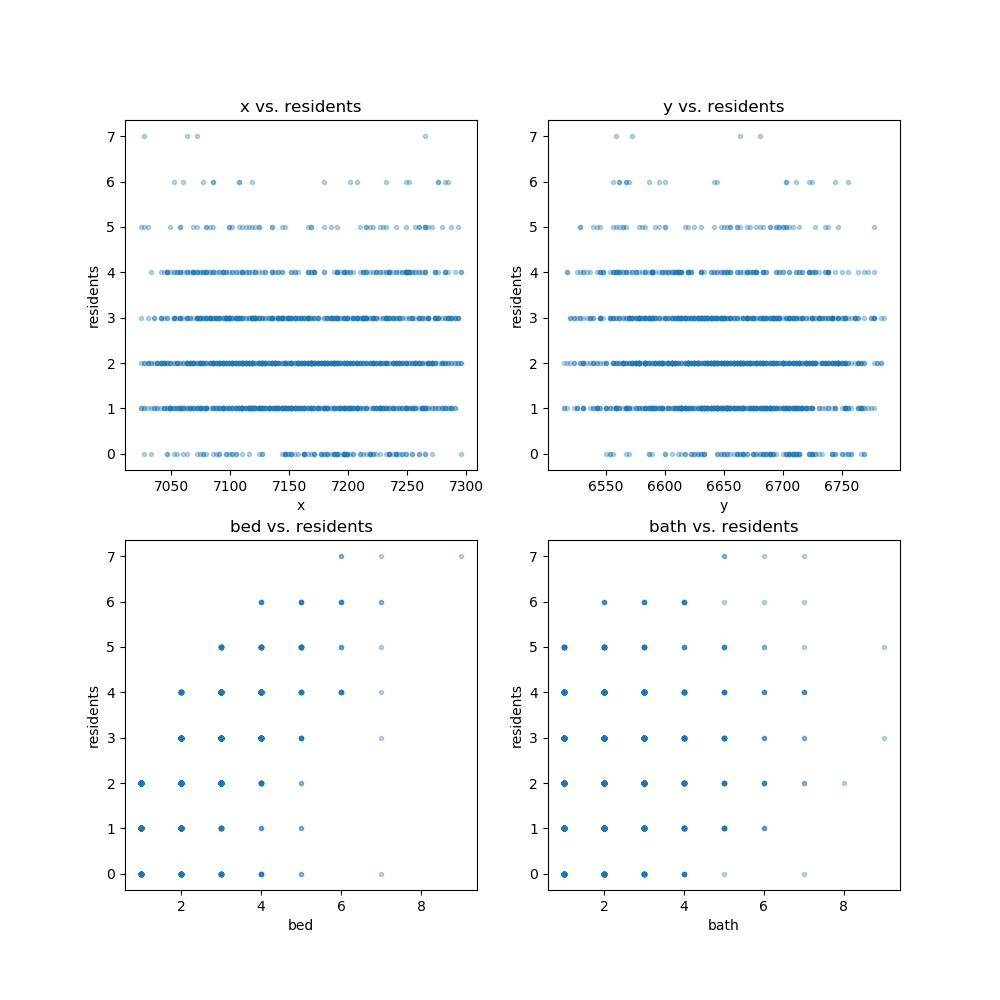

In [4]:
#Some entries in df_buildings for "residents" have NaNs.
#Let's see if there are any obvious correlations between each variable and "residents".
X = df_buildings.dropna().copy()
Y = X["residents"] #Here "Y" is used instead of "y" to avoid confusion with the spatial y co-ordinate.
X.drop(["residents"], axis=1, inplace=True)

#Location of the building doesn't seem to have a clear correlation with "residents", especially if small sample sizes are discounted (i.e. when residents = 6, 7).
#We see that "bed" is the variable with the clearest correlation to "residents". "Bath" also has a positive correlation, but it is weaker, especially with the lack of samples.
fig = plt.figure(figsize=(10,10))
graphs = [X["x"],
          X["y"],
          X["bed"],
          X["bath"]]
plot_pos = [221, 222, 223, 224]

for X_var, pos in zip(graphs, plot_pos):
    plot_2d(X_var, Y, [X_var.name, Y.name], pos, "{} vs. {}".format(X_var.name, Y.name))

#Keep only the variables with clearly strong, positive correlation.
X.drop(["x", "y", "bath"], axis=1, inplace=True)

In [5]:
#Use KNeighborsRegressor to estimate the residents based on the number of beds in a building.

#Split data into training and testing sets.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=59)

#Initialise KNeighborsRegressor and use cross-validation.
parameters = {"n_neighbors":range(1, 12, 2), "weights":["uniform", "distance"], "p":range(1, 6)}
knn_model = KNeighborsRegressor()
knn_clf = GridSearchCV(knn_model, parameters, cv=5, iid=True)

#Note that the score is mediocre, primarily because there is a sizeable distribution of beds for each number of residents per building.
knn_clf.fit(X_train, Y_train)
print("Best score is {} with parameters {}.".format(knn_clf.best_score_, knn_clf.best_params_))

#Fill the NaNs with values predicted by the regressor.
df_buildings["residents"] = df_buildings.apply(lambda row: knn_clf.predict([[row["bed"]]])[0] if np.isnan(row["residents"]) else row["residents"], axis=1)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=None,
       param_grid={'n_neighbors': range(1, 12, 2), 'weights': ['uniform', 'distance'], 'p': range(1, 6)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best score is 0.4090306274406281 with parameters {'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}.


Earliest meteorite locations.


,t,x,y,z
0,0.0,48.829115,8.475321,17005.097685
1,10.0,69.150375,69.210754,16941.295532
2,20.0,177.877729,134.011776,16831.330330
3,30.0,199.734002,220.743524,16569.077982
4,40.0,278.017526,221.403121,16849.673012


Latest meteroite locations.


,t,x,y,z
125,1250.0,6239.527790,5869.836460,3623.725794
126,1260.0,6300.375338,5904.421313,3327.550144
127,1270.0,6266.960847,5902.061941,3362.469653
128,1280.0,6290.856582,5937.913326,3230.198374
129,1290.0,6372.568988,5969.669727,2586.478643


<IPython.core.display.Javascript object>


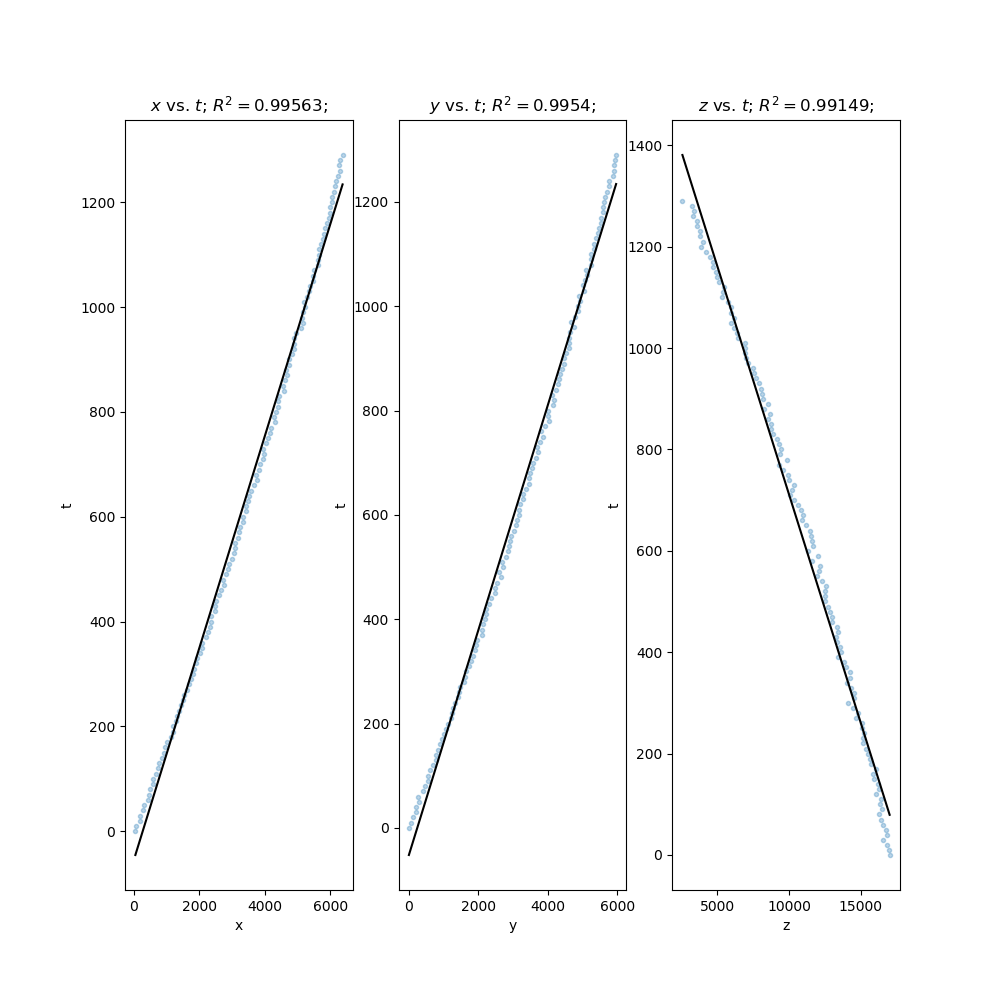

In [6]:
#Check earliest and latest meteorite locations.
print("Earliest meteorite locations.")
df_radar.head()
print("Latest meteroite locations.")
df_radar.tail()
#We see that the meteorite path data has been tracked from 17000 units to 2500 units.
#Since it has not far to go, try extrapolation. But first, let's see what interpolation looks like.

#Check how data is related for the meteorite's path.
fig = plt.figure(figsize=(10, 10))
graphs = [[df_radar.x, df_radar.t],
          [df_radar.y, df_radar.t],
          [df_radar.z, df_radar.t]]
plot_pos = [131, 132, 133]

for var, pos in zip(graphs, plot_pos):
    #Convert var[0] into a column vector to be read by sklearn.
    var0_col = np.array(var[0]).reshape(-1, 1)
    
    #Plot a linear fit for each spatial co-ordinate.
    model = linear_fit(var0_col, var[1])
    score = np.around(model.score(var0_col, var[1]), decimals=5)

    plot_2d(var[0], var[1], [var[0].name, var[1].name], pos, r"${}$ vs. ${}$; $R^2 = {}$;".format(var[0].name, var[1].name, score))
    plt.plot(var[0], model.predict(var0_col), c="black")
    

<IPython.core.display.Javascript object>


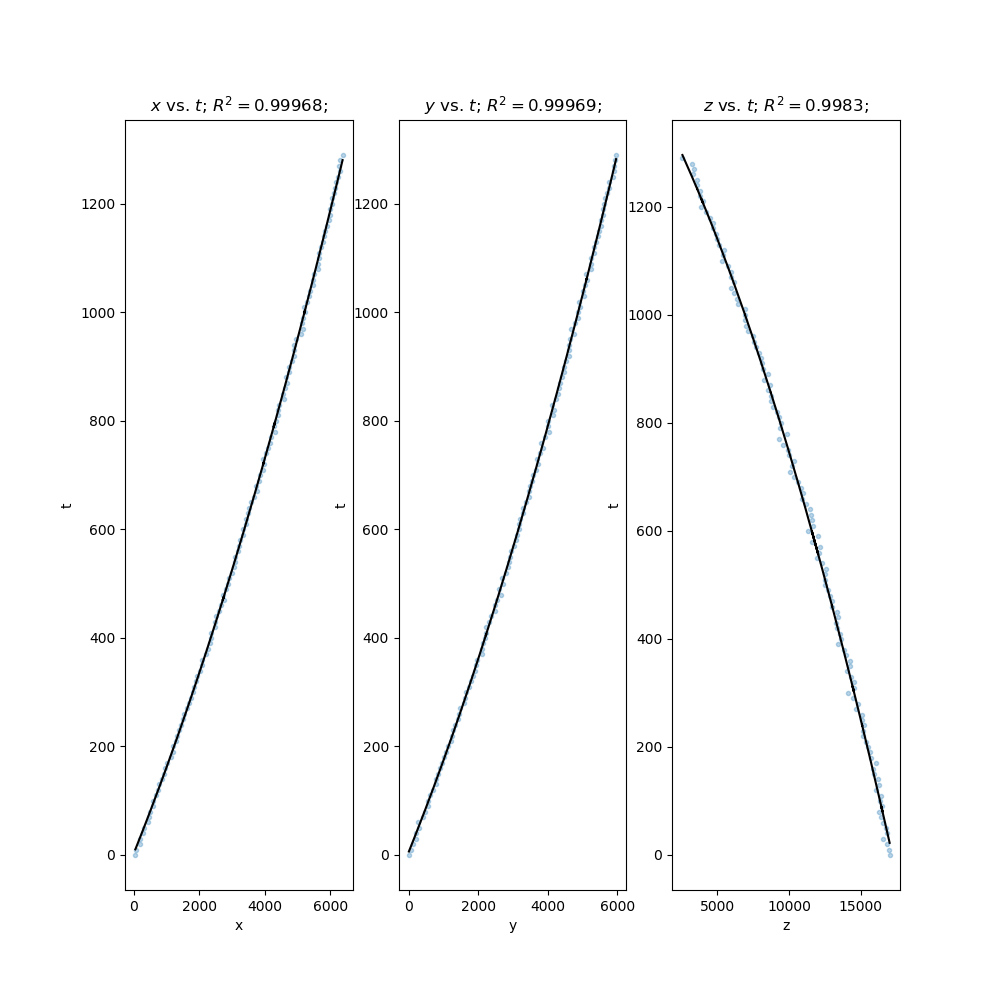

In [7]:
#Try a second-order polynomial. Note that the z-co-ordinate is not fitting quite as well as the x- and y-co-ordinates.
fig = plt.figure(figsize=(10, 10))
for var, pos in zip(graphs, plot_pos):
    var0_col = np.array(var[0]).reshape(-1, 1)
    
    #Prepare quadratic polynomial for use in the linear regression wrapper.
    poly, transf = poly_transf(var0_col, 2)
    #Do linear fit.
    model = linear_fit(transf, var[1])
    score = np.around(model.score(transf, var[1]), decimals=5)
    
    plot_2d(var[0], var[1], [var[0].name, var[1].name], pos, r"${}$ vs. ${}$; $R^2 = {}$;".format(var[0].name, var[1].name, score))
    plt.plot(var[0], model.predict(transf), c = "black")

<IPython.core.display.Javascript object>


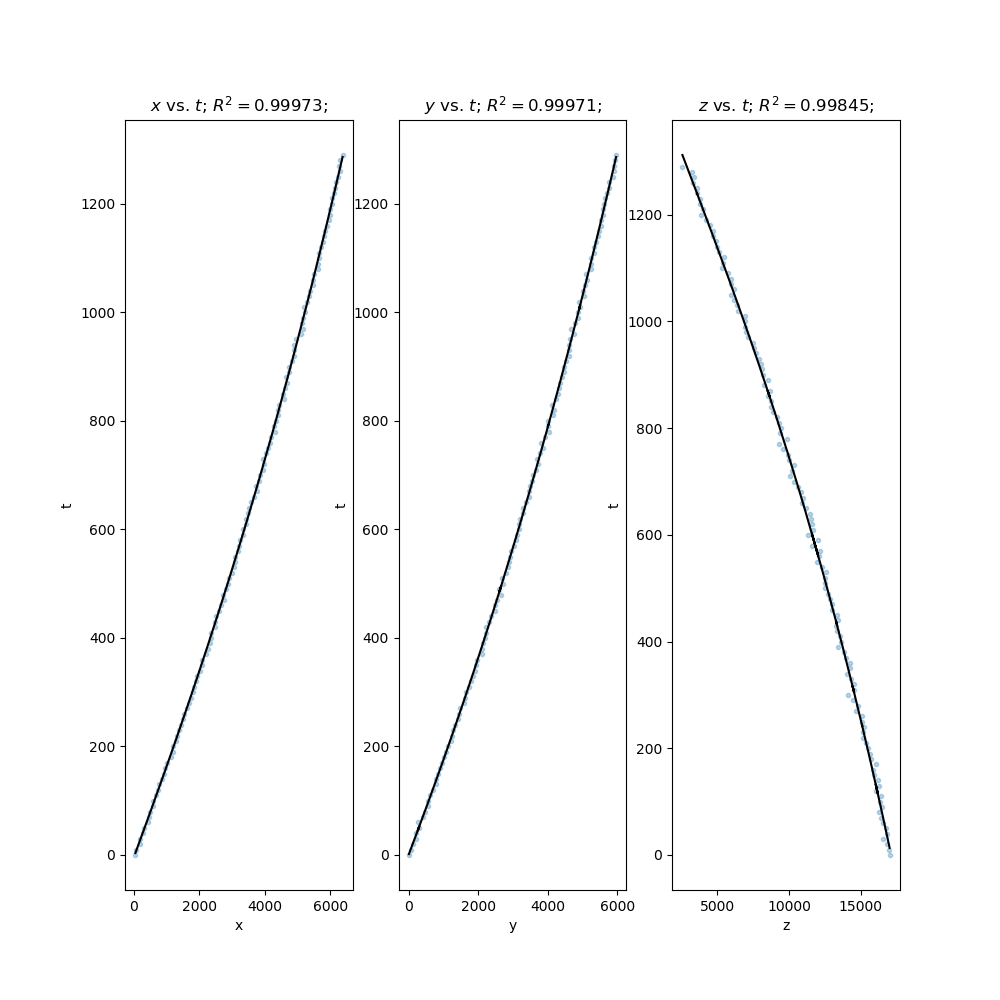

Estimated time of impact: 1494.6161824420176s.
Estimated impact location (x, y) = (7107.8554351687635, 6690.773916096978).


In [8]:
#Try a third-order polynomial. (Seems to significantly fit better than second-order on the z-co-ordinate..)
fig = plt.figure(figsize=(10, 10))
for var, pos in zip(graphs, plot_pos):
    var0_col = np.array(var[0]).reshape(-1, 1)
    
    #Prepare quadratic polynomial for use in the linear regression wrapper.
    poly, transf = poly_transf(var0_col, 3)
    #Do linear fit.
    model = linear_fit(transf, var[1])
    score = np.around(model.score(transf, var[1]), decimals=5)
    
    plot_2d(var[0], var[1], [var[0].name, var[1].name], pos, r"${}$ vs. ${}$; $R^2 = {}$;".format(var[0].name, var[1].name, score))
    plt.plot(var[0], model.predict(transf), c = "black")

#Estimate time of impact.
t_impact = model.predict(poly.transform([[0]]))
poly_t, t_transf = poly_transf(np.array(df_radar.t).reshape(-1, 1), 3)
t_impact_transf = poly_t.transform([t_impact])

#Estimate impact location
inverse_model_x = linear_fit(t_transf, df_radar.x)
inverse_model_y = linear_fit(t_transf, df_radar.y)

print("Estimated time of impact: {}s.".format(t_impact[0]))
print("Estimated impact location (x, y) = ({}, {}).".format(inverse_model_x.predict(t_impact_transf)[0], inverse_model_y.predict(t_impact_transf)[0]))


Randomly sampling 10000 times with sample sizes of 117.
The sampling took 14.67773151397705s.
The expected impact location is (x, y) = (7108.43739138398, 6691.18664110175).
The 90% confidence interval for the impact point is [(x-, x+), (y-, y+)] = [(7077.037197793931, 7157.807534085707), (6653.326730768485, 6742.753394912219)].
Plotting distribution shape of impacts.


<IPython.core.display.Javascript object>


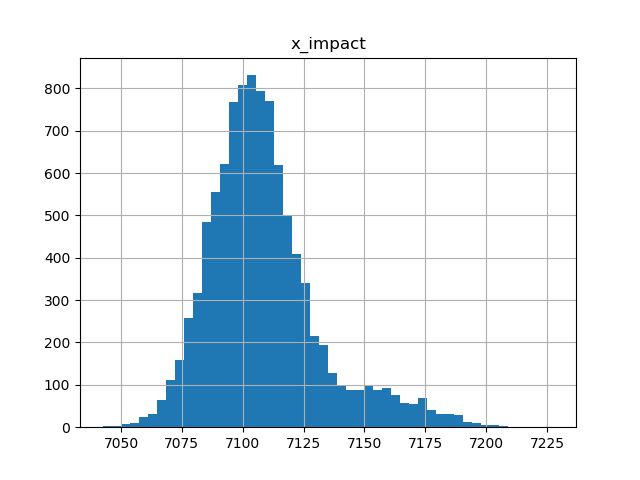

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016A29CB7860>]],
      dtype=object)

<IPython.core.display.Javascript object>


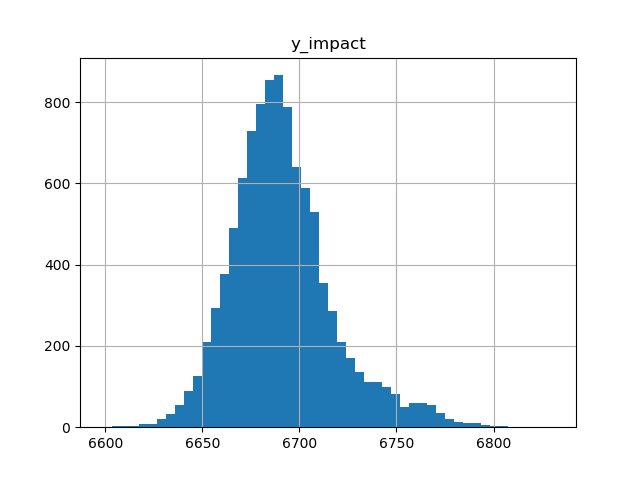

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016A29EAED30>]],
      dtype=object)

In [9]:
#Randomly sample a subset of the data repeatedly and store the expected x and y values at impact.
n_samples, sample_size = 10000, 117
print("Randomly sampling {} times with sample sizes of {}.".format(n_samples, sample_size))

s = time.time()
x_impact, y_impact = [], []
np.random.seed(191)
for n in range(n_samples):
    radar = df_radar.sample(n=sample_size)
    x, y, z, t = radar.x, radar.y, radar.z, radar.t
    z_col, t_col = np.array(z).reshape(-1, 1), np.array(t).reshape(-1, 1)
    
    #Preparing quadratic polynomial for linear regression of spatial co-ordinates.
    poly_z, z_transf = poly_transf(z_col, 3)
    
    #Do linear regression on transformed spatial co-ordinates.
    model_z = linear_fit(z_transf, t)
    
    #Predict time of impact.
    t_impact = model_z.predict(poly_z.transform([[0]]))[0]
    
    #Prepare inverse transformation to get x(t), y(t).
    poly_t, t_transf = poly_transf(t_col, 3)
    #Do inverse linear regression on untransformed x- and y-co-ordinates.
    inverse_model_x = linear_fit(t_transf, x)
    inverse_model_y = linear_fit(t_transf, y)
    
    #Calculate the impact co-ordinates.
    t_impact_transf = poly_t.transform([[t_impact]])
    x_impact.append(inverse_model_x.predict(t_impact_transf)[0])
    y_impact.append(inverse_model_y.predict(t_impact_transf)[0])

print("The sampling took {}s.".format(time.time() - s))

#Expected impact location.
x_expected_impact = np.mean(x_impact)
y_expected_impact = np.mean(y_impact)
print("The expected impact location is (x, y) = ({}, {}).".format(x_expected_impact, y_expected_impact))

#Calculate confidence intervals.
x_05, x_95 = np.percentile(x_impact, 5), np.percentile(x_impact, 95)
y_05, y_95 = np.percentile(y_impact, 5), np.percentile(y_impact, 95)
print("The 90% confidence interval for the impact point is [(x-, x+), (y-, y+)] = [({}, {}), ({}, {})].".format(x_05, x_95, y_05, y_95))

#Check distribution shape of impacts.
print("Plotting distribution shape of impacts.")
pd.DataFrame({"x_impact": x_impact}).hist(bins=50)
pd.DataFrame({"y_impact": y_impact}).hist(bins=50)

Approximately 633 residents will need to be evacuated.


<IPython.core.display.Javascript object>


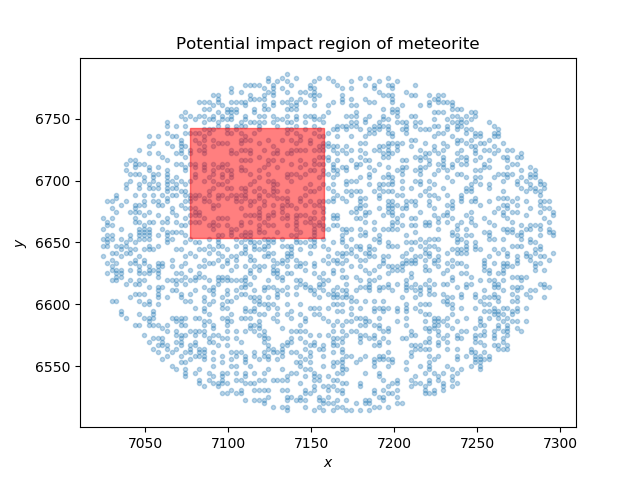

In [11]:
df_impact_zone = df_buildings[(df_buildings["x"] >= x_05) & (df_buildings["x"] <= x_95) & (df_buildings["y"] >= y_05) & (df_buildings["y"] <= y_95)]
n_evacuees = int(np.ceil(df_impact_zone.residents.sum()))
print("Approximately {} residents will need to be evacuated.".format(n_evacuees))

fig = plt.figure()
plot_2d(df_buildings.x, df_buildings.y , [r"$x$", r"$y$"], 111, "Potential impact region of meteorite")

rec = mpatches.Rectangle((x_05, y_05), x_95-x_05, y_95-y_05, alpha=0.5, color="r")
ax = fig.add_subplot(111)
ax.add_patch(rec)